### Josh Edwards
CS 4080 Project 2 Deliverables


Import libraries

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import pandas as pd
import os

Define helper functions

In [2]:
def create_output_directories():
    """Create organized directories for output files"""
    # Create directories if they don't exist
    os.makedirs('output/png', exist_ok=True)
    os.makedirs('output/csv', exist_ok=True)
    os.makedirs('output/txt', exist_ok=True)
    
    return 'Directories created: output/png, output/csv, output/txt'

Define LRU Cache Class in Python

In [3]:
# Define LRU Cache Class
class LRUCache:
    """
    Least Recently Used (LRU) cache implementation using OrderedDict.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.cache = OrderedDict()
        self.hits = 0
        self.misses = 0
        
    def get(self, key):
        """
        Get an item from the cache. If it exists, move it to the end (most recently used).
        """
        if key in self.cache:
            self.cache.move_to_end(key)
            self.hits += 1
            return self.cache[key]
        self.misses += 1
        return -1

    def put(self, key, value):
        """
        Add an item to the cache. If cache is full, remove least recently used item.
        """
        if key in self.cache:
            self.cache.move_to_end(key)
        self.cache[key] = value
        if len(self.cache) > self.capacity:
            self.cache.popitem(last=False)
    
    def get_stats(self):
        """
        Return cache performance statistics
        """
        total_operations = self.hits + self.misses
        hit_rate = self.hits / total_operations if total_operations > 0 else 0
        miss_rate = self.misses / total_operations if total_operations > 0 else 0
        return {
            'hits': self.hits,
            'misses': self.misses,
            'hit_rate': hit_rate,
            'miss_rate': miss_rate
        }
    
    def reset_stats(self):
        """
        Reset hit and miss counters
        """
        self.hits = 0
        self.misses = 0

Define LFU Cache in Python

In [4]:
# Define LFU Cache Class
class LFUCache:
    """
    Least Frequently Used (LFU) cache implementation.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.size = 0
        self.min_freq = 0
        self.cache = {}  # key -> [value, frequency, count]
        self.freq_lists = defaultdict(dict)  # frequency -> {key -> count}
        self.hits = 0
        self.misses = 0
        
    def get(self, key):
        """
        Get an item from the cache. If it exists, increment its frequency.
        """
        if key in self.cache:
            value, freq, count = self.cache[key]
            
            # Remove from current frequency list
            del self.freq_lists[freq][key]
            
            # Update min_freq if needed
            if len(self.freq_lists[freq]) == 0 and freq == self.min_freq:
                self.min_freq += 1
            
            # Update frequency and add to new frequency list
            freq += 1
            self.cache[key] = [value, freq, count]
            self.freq_lists[freq][key] = count
            
            self.hits += 1
            return value
        
        self.misses += 1
        return -1
    
    def put(self, key, value):
        """
        Add an item to the cache. If cache is full, remove least frequently used item.
        """
        if self.capacity == 0:
            return
        
        if key in self.cache:
            # Key exists, just update value and frequency
            _, freq, count = self.cache[key]
            
            # Remove from current frequency list
            del self.freq_lists[freq][key]
            
            # Update min_freq if needed
            if len(self.freq_lists[freq]) == 0 and freq == self.min_freq:
                self.min_freq += 1
            
            # Update frequency and add to new frequency list
            freq += 1
            self.cache[key] = [value, freq, count]
            self.freq_lists[freq][key] = count
        else:
            # Key doesn't exist
            if self.size == self.capacity:
                # Cache is full, remove LFU item
                # Find the key with the lowest frequency
                evict_key = next(iter(self.freq_lists[self.min_freq]))
                
                # Remove it
                del self.cache[evict_key]
                del self.freq_lists[self.min_freq][evict_key]
                self.size -= 1
                
                # Update min_freq if needed
                if len(self.freq_lists[self.min_freq]) == 0:
                    # Need to find the new min_freq, but don't need this often
                    if self.size > 0:
                        self.min_freq = min(self.freq_lists.keys())
            
            # Add new item with frequency 1
            count = time.time()  # Use timestamp as count for tie-breaking
            self.min_freq = 1
            self.cache[key] = [value, 1, count]
            self.freq_lists[1][key] = count
            self.size += 1
    
    def get_stats(self):
        """
        Return cache performance statistics
        """
        total_operations = self.hits + self.misses
        hit_rate = self.hits / total_operations if total_operations > 0 else 0
        miss_rate = self.misses / total_operations if total_operations > 0 else 0
        return {
            'hits': self.hits,
            'misses': self.misses,
            'hit_rate': hit_rate,
            'miss_rate': miss_rate
        }
    
    def reset_stats(self):
        """
        Reset hit and miss counters
        """
        self.hits = 0
        self.misses = 0

Define experiment function. Is called by main() later. 

In [5]:
def run_experiment(alphabet_sizes, cache_ratios, request_sequence_length=10000, runs=5):
    """
    Run experiments with different cache sizes (as ratios of alphabet size) 
    and alphabet sizes using uniform distribution for both LRU and LFU caches.
    
    Args:
        alphabet_sizes: List of alphabet sizes to test
        cache_ratios: List of cache-to-alphabet ratios to test (0-1.0)
        request_sequence_length: Length of the request sequence
        runs: Number of runs for each configuration
        
    Returns:
        Dictionary with LRU and LFU results as DataFrames
    """
    lru_results = []
    lfu_results = []
    
    for alphabet_size in alphabet_sizes:
        for ratio in cache_ratios:
            # Calculate actual cache size as a ratio of alphabet size
            cache_size = int(alphabet_size * ratio)
            if cache_size == 0:  # Avoid cache size of 0
                cache_size = 1
                
            print(f"Running experiment: cache_size={cache_size}, alphabet_size={alphabet_size}, ratio={ratio:.2f}")
            
            lru_hit_rates = []
            lru_runtimes = []
            lru_memory_usages = []
            
            lfu_hit_rates = []
            lfu_runtimes = []
            lfu_memory_usages = []
            
            for run in range(runs):
                # Create LRU and LFU caches
                lru = LRUCache(cache_size)
                lfu = LFUCache(cache_size)
                
                # Generate uniform random request sequence
                alphabet = list(range(alphabet_size))
                requests = np.random.choice(alphabet, size=request_sequence_length)
                
                # Process requests for LRU
                start_time = time.time()
                for request in requests:
                    if lru.get(request) == -1:
                        # Cache miss, add to cache
                        lru.put(request, f"value_{request}")
                lru_runtime = time.time() - start_time
                
                # Process requests for LFU (using same sequence)
                start_time = time.time()
                for request in requests:
                    if lfu.get(request) == -1:
                        # Cache miss, add to cache
                        lfu.put(request, f"value_{request}")
                lfu_runtime = time.time() - start_time
                
                # Get stats
                lru_stats = lru.get_stats()
                lfu_stats = lfu.get_stats()
                
                lru_hit_rates.append(lru_stats['hit_rate'])
                lru_runtimes.append(lru_runtime)
                
                lfu_hit_rates.append(lfu_stats['hit_rate'])
                lfu_runtimes.append(lfu_runtime)
                
                # Approximate memory usage (in bytes)
                # LRU: Each entry has a key (4 bytes) and value reference (~28 bytes for small strings)
                lru_memory_usage = cache_size * (4 + 28)
                
                # LFU: Additional overhead for frequency tracking
                lfu_memory_usage = cache_size * (4 + 28 + 4 + 8) + 8 * min(cache_size, alphabet_size)
                
                lru_memory_usages.append(lru_memory_usage)
                lfu_memory_usages.append(lfu_memory_usage)
                
                lru.reset_stats()
                lfu.reset_stats()
            
            # Save average results for LRU
            lru_results.append({
                'cache_size': cache_size,
                'alphabet_size': alphabet_size,
                'cache_ratio': ratio,
                'avg_hit_rate': np.mean(lru_hit_rates),
                'avg_miss_rate': 1 - np.mean(lru_hit_rates),
                'avg_runtime': np.mean(lru_runtimes),
                'avg_memory_usage': np.mean(lru_memory_usages)
            })
            
            # Save average results for LFU
            lfu_results.append({
                'cache_size': cache_size,
                'alphabet_size': alphabet_size,
                'cache_ratio': ratio,
                'avg_hit_rate': np.mean(lfu_hit_rates),
                'avg_miss_rate': 1 - np.mean(lfu_hit_rates),
                'avg_runtime': np.mean(lfu_runtimes),
                'avg_memory_usage': np.mean(lfu_memory_usages)
            })
    
    return {
        'lru': pd.DataFrame(lru_results),
        'lfu': pd.DataFrame(lfu_results)
    }

### Plot results

In [6]:
def plot_comparison_results(results, request_sequence_length):
    """
    Create comparative visualizations of LRU vs LFU performance
    """
    # Set a professional style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Extract dataframes
    lru_results = results['lru']
    lfu_results = results['lfu']
    
    # Define a professional color palette
    alphabet_sizes = sorted(lru_results['alphabet_size'].unique())
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(alphabet_sizes)))
    
    # Common figure settings
    fig_size = (12, 8)
    dpi = 300
    font_size = 14
    title_size = 18
    legend_size = 12
    
    # Plot 1: Hit rate vs Cache Ratio (LRU vs LFU)
    plt.figure(figsize=fig_size, dpi=dpi)
    
    # Define distinct markers for LRU and LFU
    lru_marker = 'o'  # circle
    lfu_marker = 's'  # square
    
    # Group by alphabet size
    for i, alphabet_size in enumerate(alphabet_sizes):
        # Plot LRU with lines connecting points
        lru_subset = lru_results[lru_results['alphabet_size'] == alphabet_size]
        plt.plot(lru_subset['cache_ratio'], lru_subset['avg_hit_rate'], 
                marker=lru_marker, markersize=8, linewidth=2, color=colors[i],
                label=f'LRU - A={alphabet_size}')
        
        # Plot LFU with dashed lines
        lfu_subset = lfu_results[lfu_results['alphabet_size'] == alphabet_size]
        plt.plot(lfu_subset['cache_ratio'], lfu_subset['avg_hit_rate'], 
                marker=lfu_marker, markersize=8, linewidth=2, color=colors[i], linestyle='--',
                label=f'LFU - A={alphabet_size}')
    
    # Add theoretical line
    x = np.linspace(0, 1.0, 100)
    y = np.minimum(x, 1.0)  # Hit rate can't exceed 1.0
    plt.plot(x, y, 'r-', linewidth=2, label='Theoretical (Uniform)')
    
    # Set x-axis limits and ticks
    plt.xlim(0, 1.0)
    plt.xticks(np.arange(0, 1.1, 0.2))
    
    plt.xlabel('(Cache Size / Alphabet Size) Ratio', fontsize=font_size)
    plt.ylabel('Hit Rate', fontsize=font_size)
    plt.title('Hit Rate vs Cache Ratio: LRU vs LFU Comparison', fontsize=title_size, fontweight='bold')
    plt.legend(fontsize=legend_size)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('output/png/hit_rate_comparison.png', bbox_inches='tight')
    
    # Plot 2: Runtime vs Cache Ratio (LRU vs LFU)
    plt.figure(figsize=fig_size, dpi=dpi)
    
    for i, alphabet_size in enumerate(alphabet_sizes):
        # Plot LRU
        lru_subset = lru_results[lru_results['alphabet_size'] == alphabet_size]
        plt.plot(lru_subset['cache_ratio'], lru_subset['avg_runtime'], 
                marker=lru_marker, markersize=8, linewidth=2, color=colors[i],
                label=f'LRU - A={alphabet_size}')
        
        # Plot LFU
        lfu_subset = lfu_results[lfu_results['alphabet_size'] == alphabet_size]
        plt.plot(lfu_subset['cache_ratio'], lfu_subset['avg_runtime'], 
                marker=lfu_marker, markersize=8, linewidth=2, color=colors[i], linestyle='--',
                label=f'LFU - A={alphabet_size}')
    
    plt.xlabel('Cache Ratio', fontsize=font_size)
    plt.ylabel('Average Runtime (seconds)', fontsize=font_size)
    plt.title('Runtime Performance: LRU vs LFU Comparison', fontsize=title_size, fontweight='bold')
    plt.legend(fontsize=legend_size)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('output/png/runtime_comparison.png', bbox_inches='tight')
    
    # Plot 3: Memory Usage vs Cache Ratio (LRU vs LFU)
    plt.figure(figsize=fig_size, dpi=dpi)
    
    for i, alphabet_size in enumerate(alphabet_sizes):
        # Plot LRU
        lru_subset = lru_results[lru_results['alphabet_size'] == alphabet_size]
        plt.plot(lru_subset['cache_ratio'], lru_subset['avg_memory_usage'] / 1024, 
                marker=lru_marker, markersize=8, linewidth=2, color=colors[i],
                label=f'LRU - A={alphabet_size}')
        
        # Plot LFU
        lfu_subset = lfu_results[lfu_results['alphabet_size'] == alphabet_size]
        plt.plot(lfu_subset['cache_ratio'], lfu_subset['avg_memory_usage'] / 1024, 
                marker=lfu_marker, markersize=8, linewidth=2, color=colors[i], linestyle='--',
                label=f'LFU - A={alphabet_size}')
    
    plt.xlabel('Cache Ratio', fontsize=font_size)
    plt.ylabel('Memory Usage (KB)', fontsize=font_size)
    plt.title('Memory Usage: LRU vs LFU Comparison', fontsize=title_size, fontweight='bold')
    plt.legend(fontsize=legend_size)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('output/png/memory_comparison.png', bbox_inches='tight')
    
    # Plot 4: Combined Performance Metrics
    fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=dpi)
    
    # Top Left: Hit rate vs Cache Ratio
    for i, alphabet_size in enumerate(alphabet_sizes):
        # Plot LRU
        lru_subset = lru_results[lru_results['alphabet_size'] == alphabet_size]
        axs[0, 0].plot(lru_subset['cache_ratio'], lru_subset['avg_hit_rate'], 
                    marker=lru_marker, markersize=6, linewidth=2, color=colors[i],
                    label=f'LRU - A={alphabet_size}')
        
        # Plot LFU
        lfu_subset = lfu_results[lfu_results['alphabet_size'] == alphabet_size]
        axs[0, 0].plot(lfu_subset['cache_ratio'], lfu_subset['avg_hit_rate'], 
                    marker=lfu_marker, markersize=6, linewidth=2, color=colors[i], linestyle='--',
                    label=f'LFU - A={alphabet_size}')
    
    # Add theoretical line
    x = np.linspace(0, 1.0, 100)
    y = np.minimum(x, 1.0)  # Hit rate can't exceed 1.0
    axs[0, 0].plot(x, y, 'r-', linewidth=2, label='Theoretical')
    
    # Set x-axis limits and ticks
    axs[0, 0].set_xlim(0, 1.0)
    axs[0, 0].set_xticks(np.arange(0, 1.1, 0.2))
    
    axs[0, 0].set_xlabel('Cache Ratio', fontsize=font_size-2)
    axs[0, 0].set_ylabel('Hit Rate', fontsize=font_size-2)
    axs[0, 0].set_title('Hit Rate vs Cache Ratio', fontsize=font_size, fontweight='bold')
    axs[0, 0].legend(fontsize=legend_size-4, ncol=2)
    axs[0, 0].grid(True, alpha=0.3)
    
    # Top Right: Runtime vs Cache Ratio
    for i, alphabet_size in enumerate(alphabet_sizes):
        # Plot LRU
        lru_subset = lru_results[lru_results['alphabet_size'] == alphabet_size]
        axs[0, 1].plot(lru_subset['cache_ratio'], lru_subset['avg_runtime'], 
                    marker=lru_marker, markersize=6, linewidth=2, color=colors[i],
                    label=f'LRU - A={alphabet_size}')
        
        # Plot LFU
        lfu_subset = lfu_results[lfu_results['alphabet_size'] == alphabet_size]
        axs[0, 1].plot(lfu_subset['cache_ratio'], lfu_subset['avg_runtime'], 
                    marker=lfu_marker, markersize=6, linewidth=2, color=colors[i], linestyle='--',
                    label=f'LFU - A={alphabet_size}')
    
    axs[0, 1].set_xlabel('Cache Ratio', fontsize=font_size-2)
    axs[0, 1].set_ylabel('Runtime (s)', fontsize=font_size-2)
    axs[0, 1].set_title('Runtime vs Cache Ratio', fontsize=font_size, fontweight='bold')
    axs[0, 1].legend(fontsize=legend_size-4, ncol=2)
    axs[0, 1].grid(True, alpha=0.3)
    
    # Bottom Left: Hit Rate Difference (LFU - LRU)
    # Merge the dataframes on cache_ratio and alphabet_size
    merged_results = pd.merge(
        lru_results, 
        lfu_results,
        on=['cache_ratio', 'alphabet_size'],
        suffixes=('_lru', '_lfu')
    )
    
    # Calculate the hit rate difference
    merged_results['hit_rate_diff'] = merged_results['avg_hit_rate_lfu'] - merged_results['avg_hit_rate_lru']
    
    for i, alphabet_size in enumerate(alphabet_sizes):
        subset = merged_results[merged_results['alphabet_size'] == alphabet_size]
        axs[1, 0].plot(subset['cache_ratio'], subset['hit_rate_diff'], 
                    marker='o', markersize=6, linewidth=2, color=colors[i],
                    label=f'A={alphabet_size}')
    
    axs[1, 0].axhline(y=0, color='r', linestyle='-', linewidth=1)
    axs[1, 0].set_xlabel('Cache Ratio', fontsize=font_size-2)
    axs[1, 0].set_ylabel('Hit Rate Difference (LFU - LRU)', fontsize=font_size-2)
    axs[1, 0].set_title('Hit Rate Difference', fontsize=font_size, fontweight='bold')
    axs[1, 0].legend(fontsize=legend_size-4)
    axs[1, 0].grid(True, alpha=0.3)
    
    # Bottom Right: Runtime Ratio (LFU / LRU)
    merged_results['runtime_ratio'] = merged_results['avg_runtime_lfu'] / merged_results['avg_runtime_lru']
    
    for i, alphabet_size in enumerate(alphabet_sizes):
        subset = merged_results[merged_results['alphabet_size'] == alphabet_size]
        axs[1, 1].plot(subset['cache_ratio'], subset['runtime_ratio'], 
                    marker='o', markersize=6, linewidth=2, color=colors[i],
                    label=f'A={alphabet_size}')
    
    axs[1, 1].axhline(y=1, color='r', linestyle='-', linewidth=1)
    axs[1, 1].set_xlabel('Cache Ratio', fontsize=font_size-2)
    axs[1, 1].set_ylabel('Runtime Ratio (LFU / LRU)', fontsize=font_size-2)
    axs[1, 1].set_title('Runtime Ratio', fontsize=font_size, fontweight='bold')
    axs[1, 1].legend(fontsize=legend_size-4)
    axs[1, 1].grid(True, alpha=0.3)
    
    # Overall title
    fig.suptitle('LRU vs LFU Cache Performance Comparison', fontsize=title_size+2, fontweight='bold', y=0.98)
    
    # Add experiment details
    experiment_details = (
        f"Experiment Details:\n"
        f"• Cache ratios: {', '.join([f'{r:.2f}' for r in sorted(lru_results['cache_ratio'].unique())])}\n"
        f"• Alphabet sizes: {', '.join(map(str, alphabet_sizes))}\n"
        f"• Request sequence length: {request_sequence_length:,}"
    )
    
    fig.text(0.5, 0.01, experiment_details, ha='center', 
            fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('output/png/lru_vs_lfu_summary.png', bbox_inches='tight')
    
    return

Function to plot Empirical (real) Results vs. Theoretical (predicted) Results.

In [7]:
def plot_empirical_vs_theoretical(results):
    """
    Create a plot comparing empirical vs theoretical hit rates for both LRU and LFU
    """
    # Set a professional style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Extract dataframes
    lru_results = results['lru']
    lfu_results = results['lfu']
    
    # Calculate theoretical hit rates (for uniform distribution)
    lru_results['theoretical_hit_rate'] = lru_results['cache_ratio']
    lfu_results['theoretical_hit_rate'] = lfu_results['cache_ratio']
    
    # Setup the figure
    fig_size = (12, 8)
    dpi = 300
    font_size = 14
    title_size = 18
    
    plt.figure(figsize=fig_size, dpi=dpi)
    
    # Define markers and colors for better distinction
    lru_marker = 'o'  # circle
    lfu_marker = 's'  # square
    lru_color = 'blue'
    lfu_color = 'green'
    
    # Plot LRU points
    plt.scatter(lru_results['theoretical_hit_rate'], lru_results['avg_hit_rate'], 
               marker=lru_marker, s=80, color=lru_color, alpha=0.7, 
               label='LRU')
    
    # Plot LFU points
    plt.scatter(lfu_results['theoretical_hit_rate'], lfu_results['avg_hit_rate'], 
               marker=lfu_marker, s=80, color=lfu_color, alpha=0.7, 
               label='LFU')
    
    # Add diagonal line for perfect match
    max_val = max(
        lru_results['theoretical_hit_rate'].max(), 
        lru_results['avg_hit_rate'].max(),
        lfu_results['theoretical_hit_rate'].max(), 
        lfu_results['avg_hit_rate'].max()
    ) + 0.05
    
    plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Match')
    
    # Add labels and title
    plt.xlabel('Theoretical Hit Rate (cache_ratio)', fontsize=font_size)
    plt.ylabel('Empirical Hit Rate', fontsize=font_size)
    plt.title('Empirical vs Theoretical Hit Rate: LRU vs LFU', fontsize=title_size, fontweight='bold')
    
    # Add correlation coefficients to the plot
    lru_correlation = np.corrcoef(lru_results['theoretical_hit_rate'], lru_results['avg_hit_rate'])[0, 1]
    lfu_correlation = np.corrcoef(lfu_results['theoretical_hit_rate'], lfu_results['avg_hit_rate'])[0, 1]
    
    plt.annotate(f"LRU Correlation: {lru_correlation:.4f}", 
                xy=(0.05, 0.95), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8))
    
    plt.annotate(f"LFU Correlation: {lfu_correlation:.4f}", 
                xy=(0.05, 0.90), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))
    
    # Add legend and grid
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('output/png/empirical_vs_theoretical.png', bbox_inches='tight')
    
    return

Main execution function, generates plots. 

Running experiment: cache_size=1, alphabet_size=100, ratio=0.01
Running experiment: cache_size=5, alphabet_size=100, ratio=0.05
Running experiment: cache_size=10, alphabet_size=100, ratio=0.10
Running experiment: cache_size=20, alphabet_size=100, ratio=0.20
Running experiment: cache_size=40, alphabet_size=100, ratio=0.40
Running experiment: cache_size=60, alphabet_size=100, ratio=0.60
Running experiment: cache_size=80, alphabet_size=100, ratio=0.80
Running experiment: cache_size=100, alphabet_size=100, ratio=1.00
Running experiment: cache_size=5, alphabet_size=500, ratio=0.01
Running experiment: cache_size=25, alphabet_size=500, ratio=0.05
Running experiment: cache_size=50, alphabet_size=500, ratio=0.10
Running experiment: cache_size=100, alphabet_size=500, ratio=0.20
Running experiment: cache_size=200, alphabet_size=500, ratio=0.40
Running experiment: cache_size=300, alphabet_size=500, ratio=0.60
Running experiment: cache_size=400, alphabet_size=500, ratio=0.80
Running experiment: cac

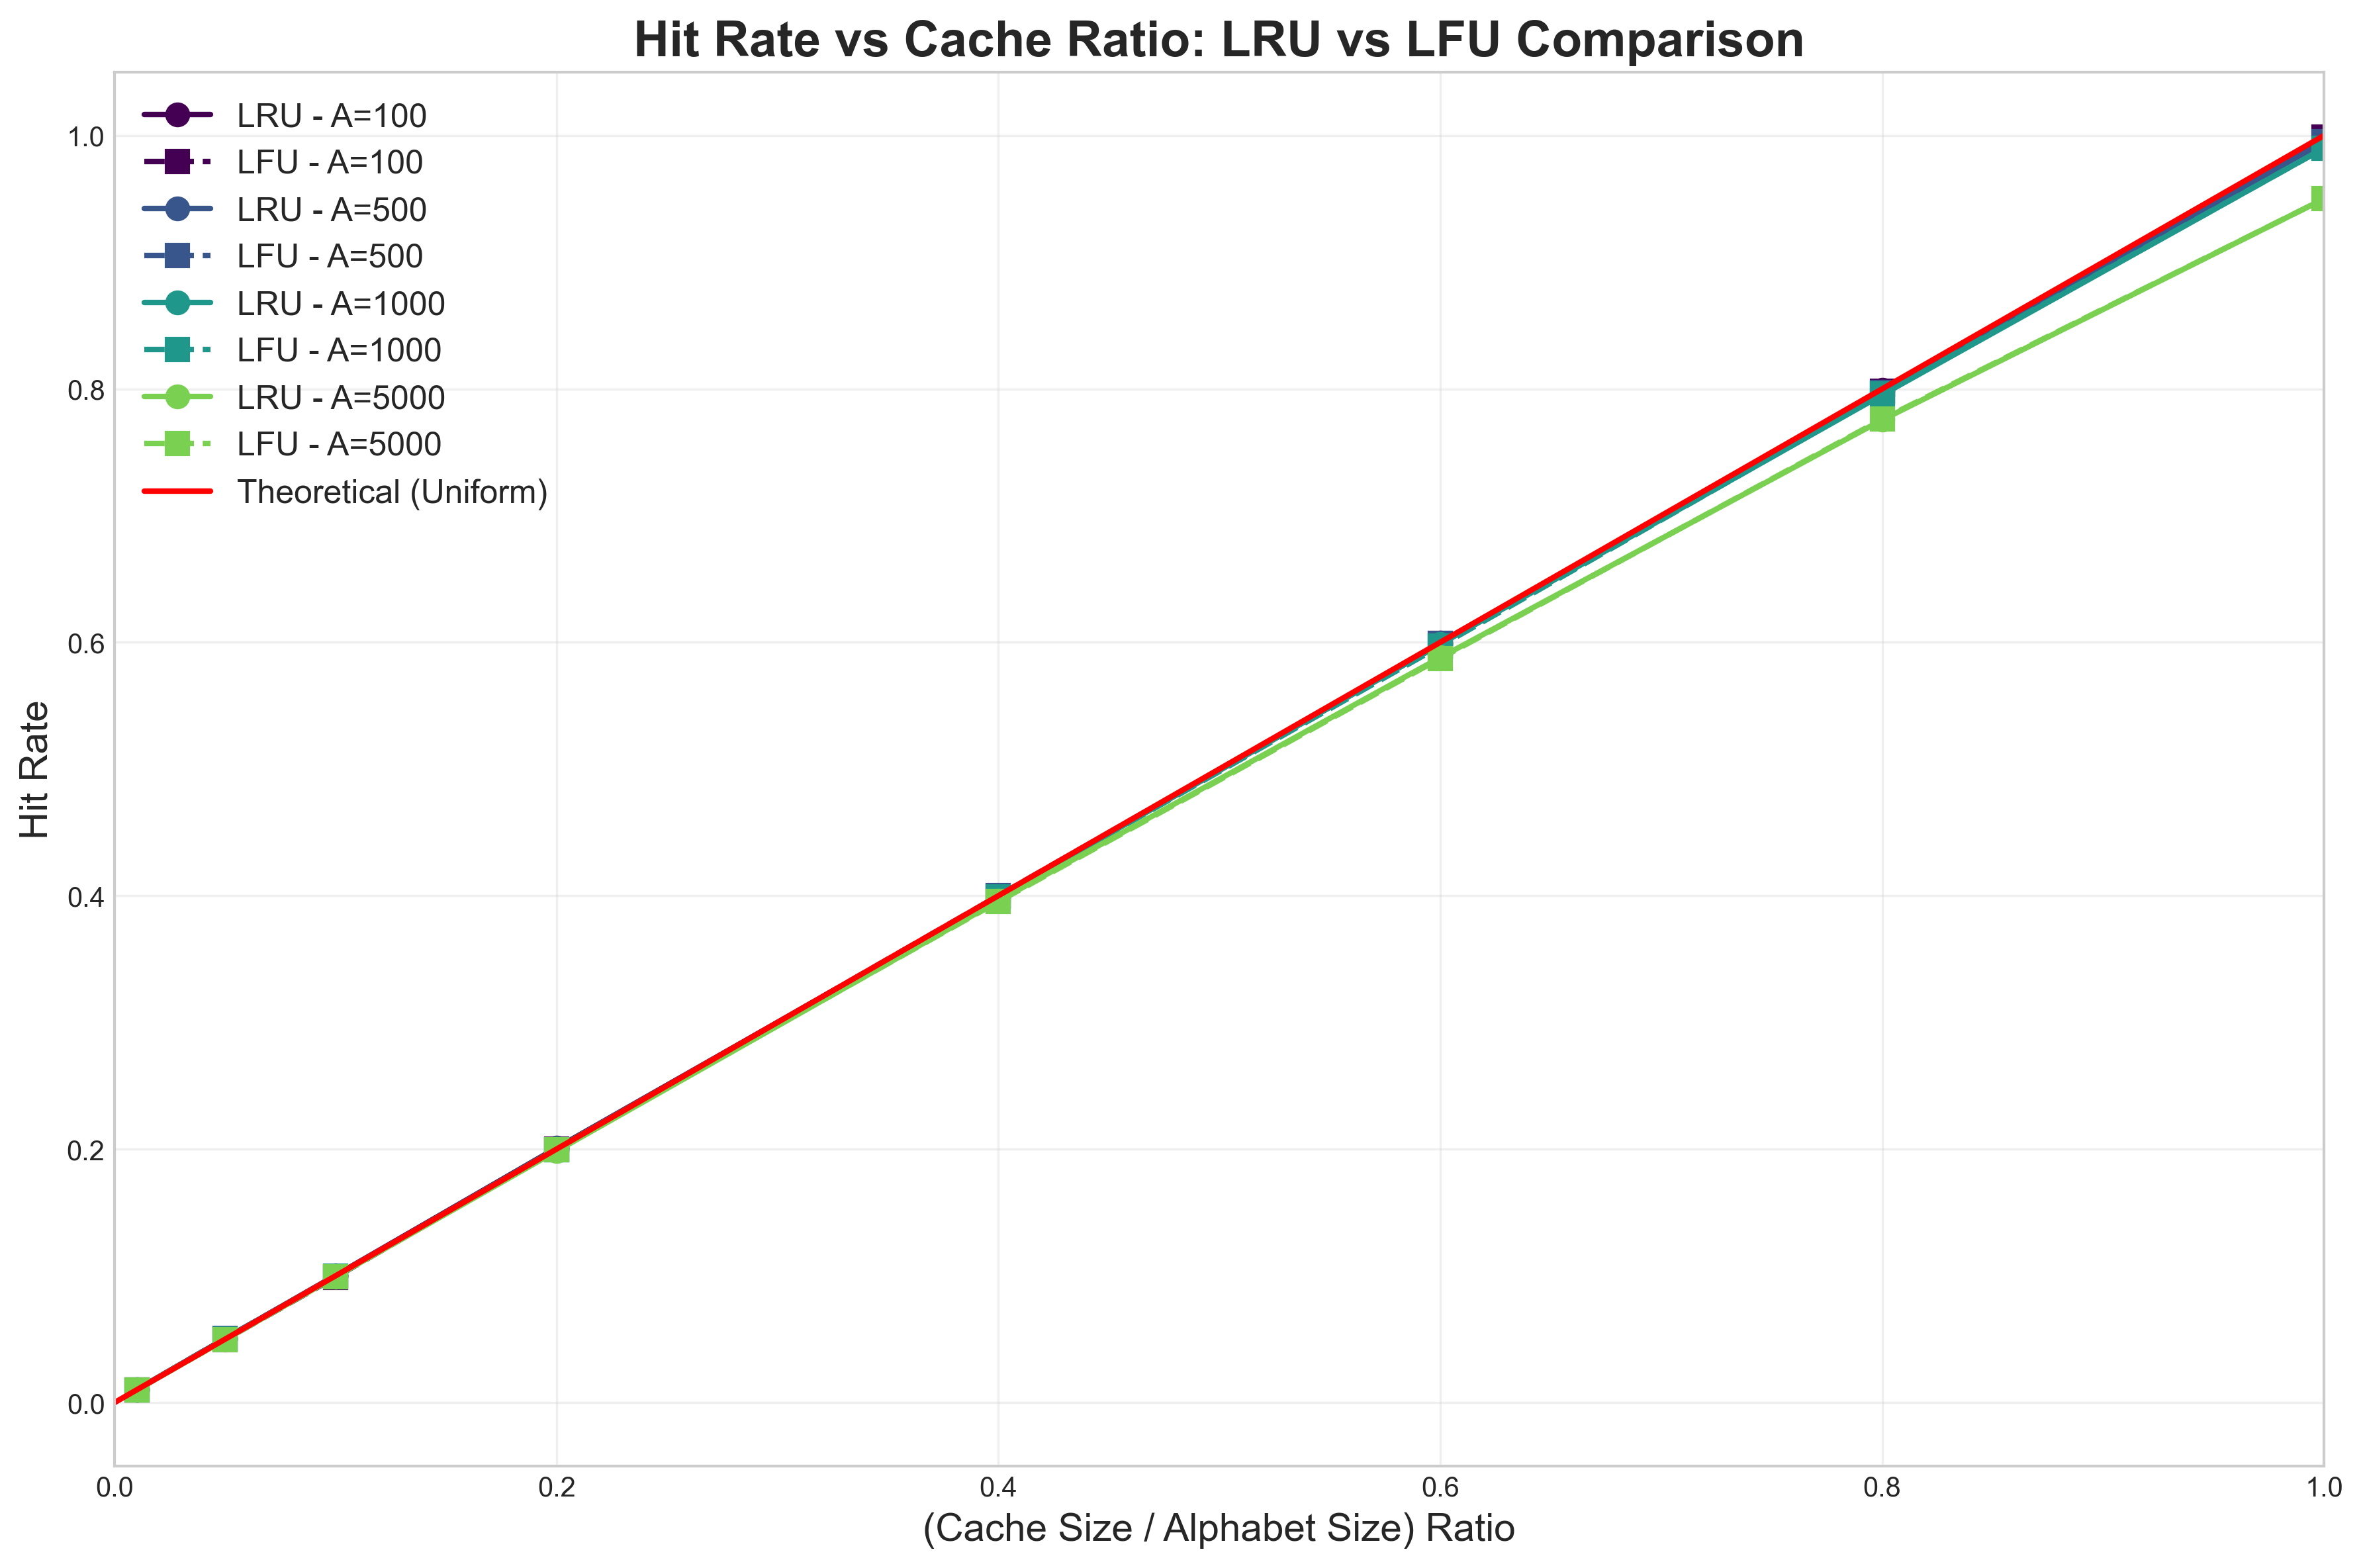

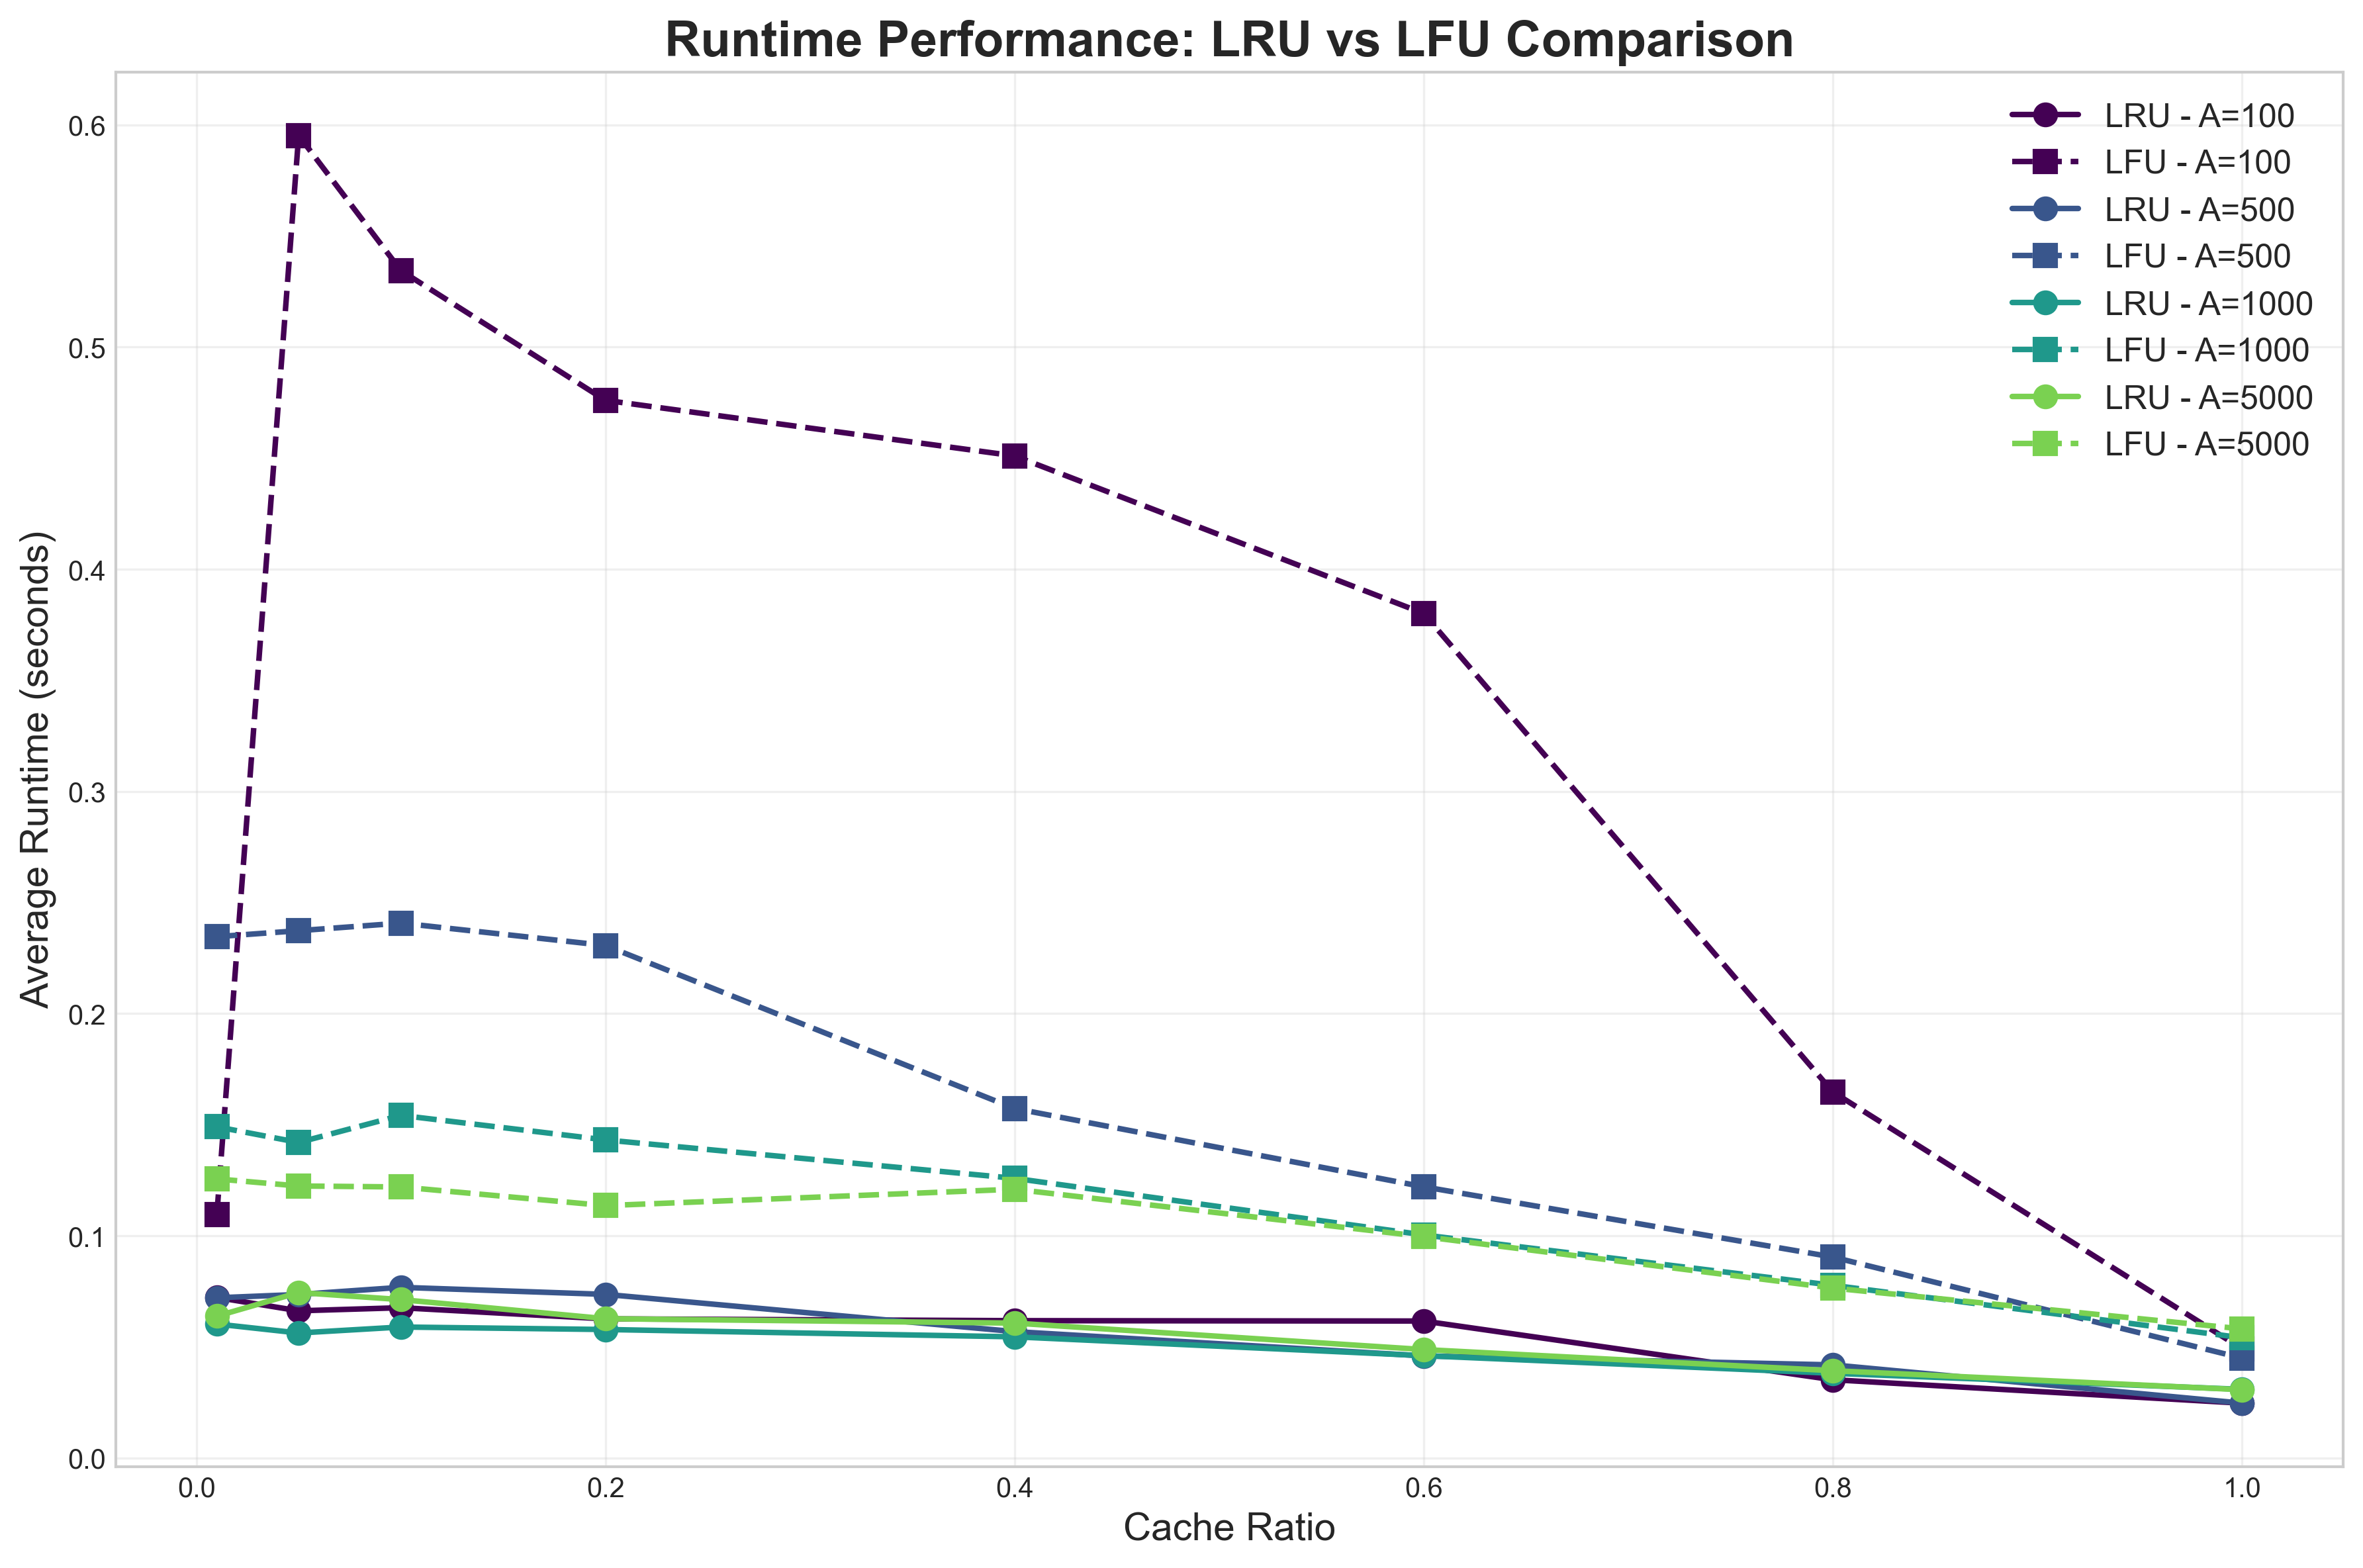

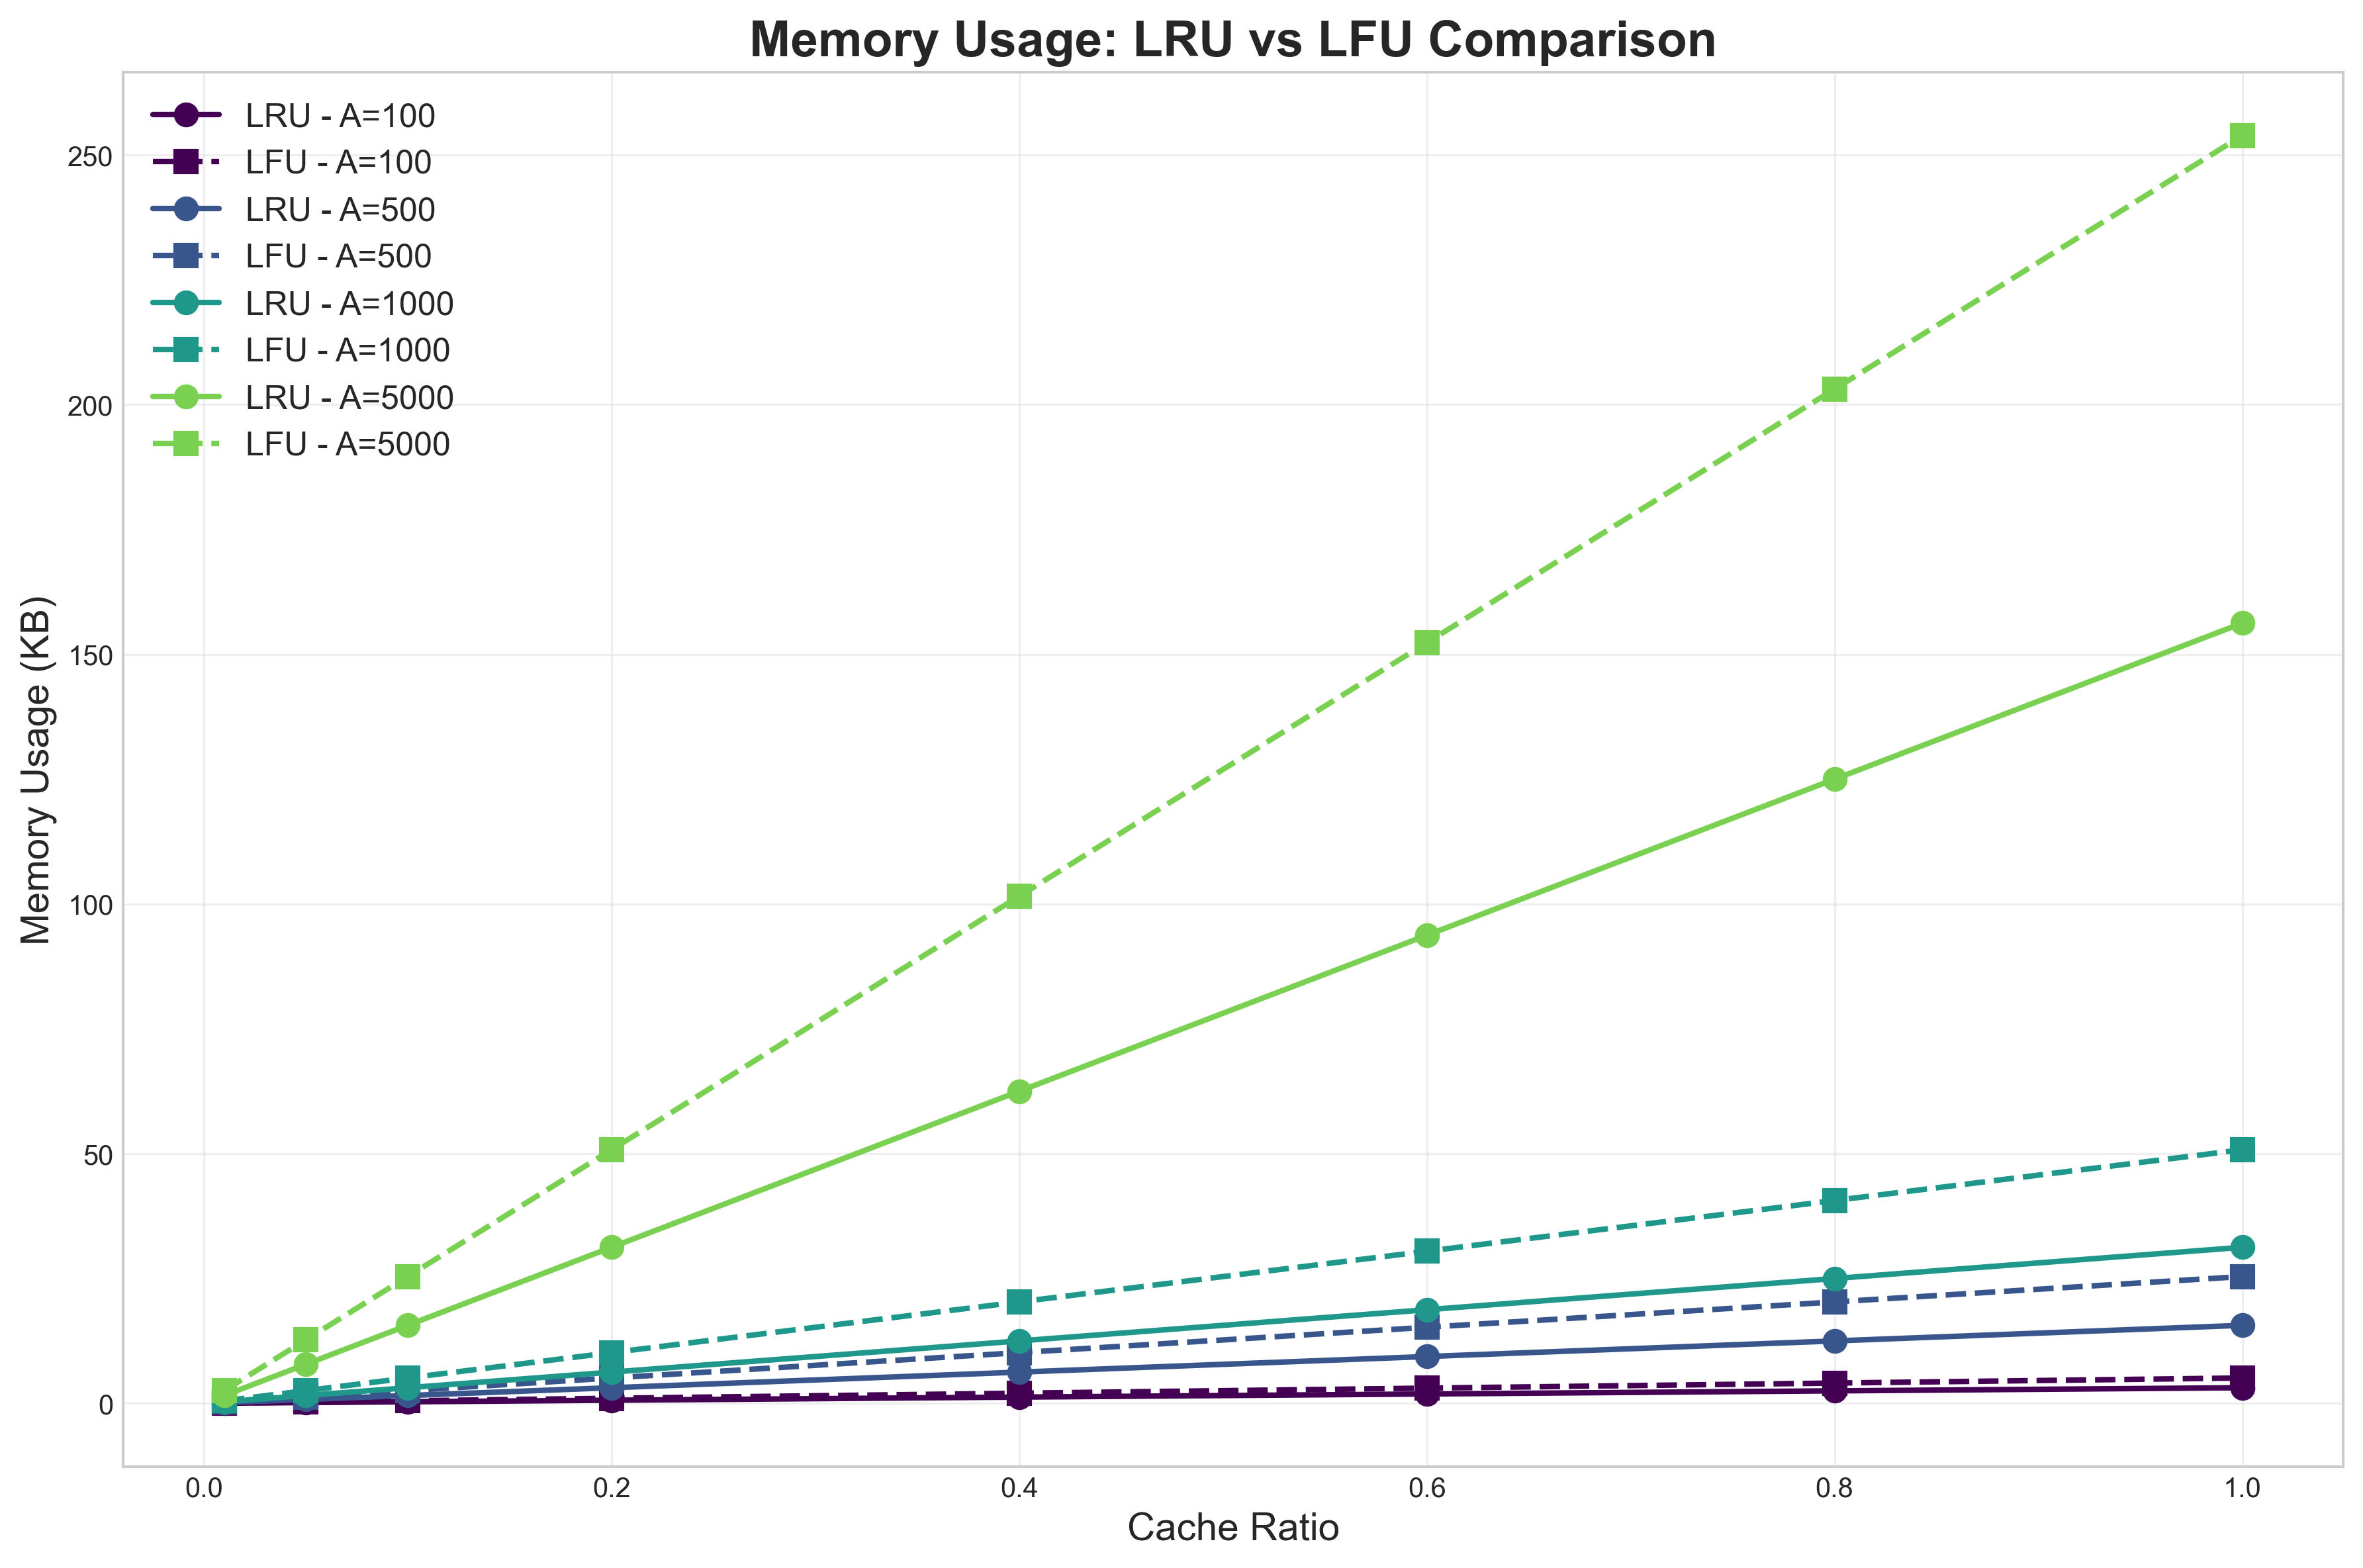

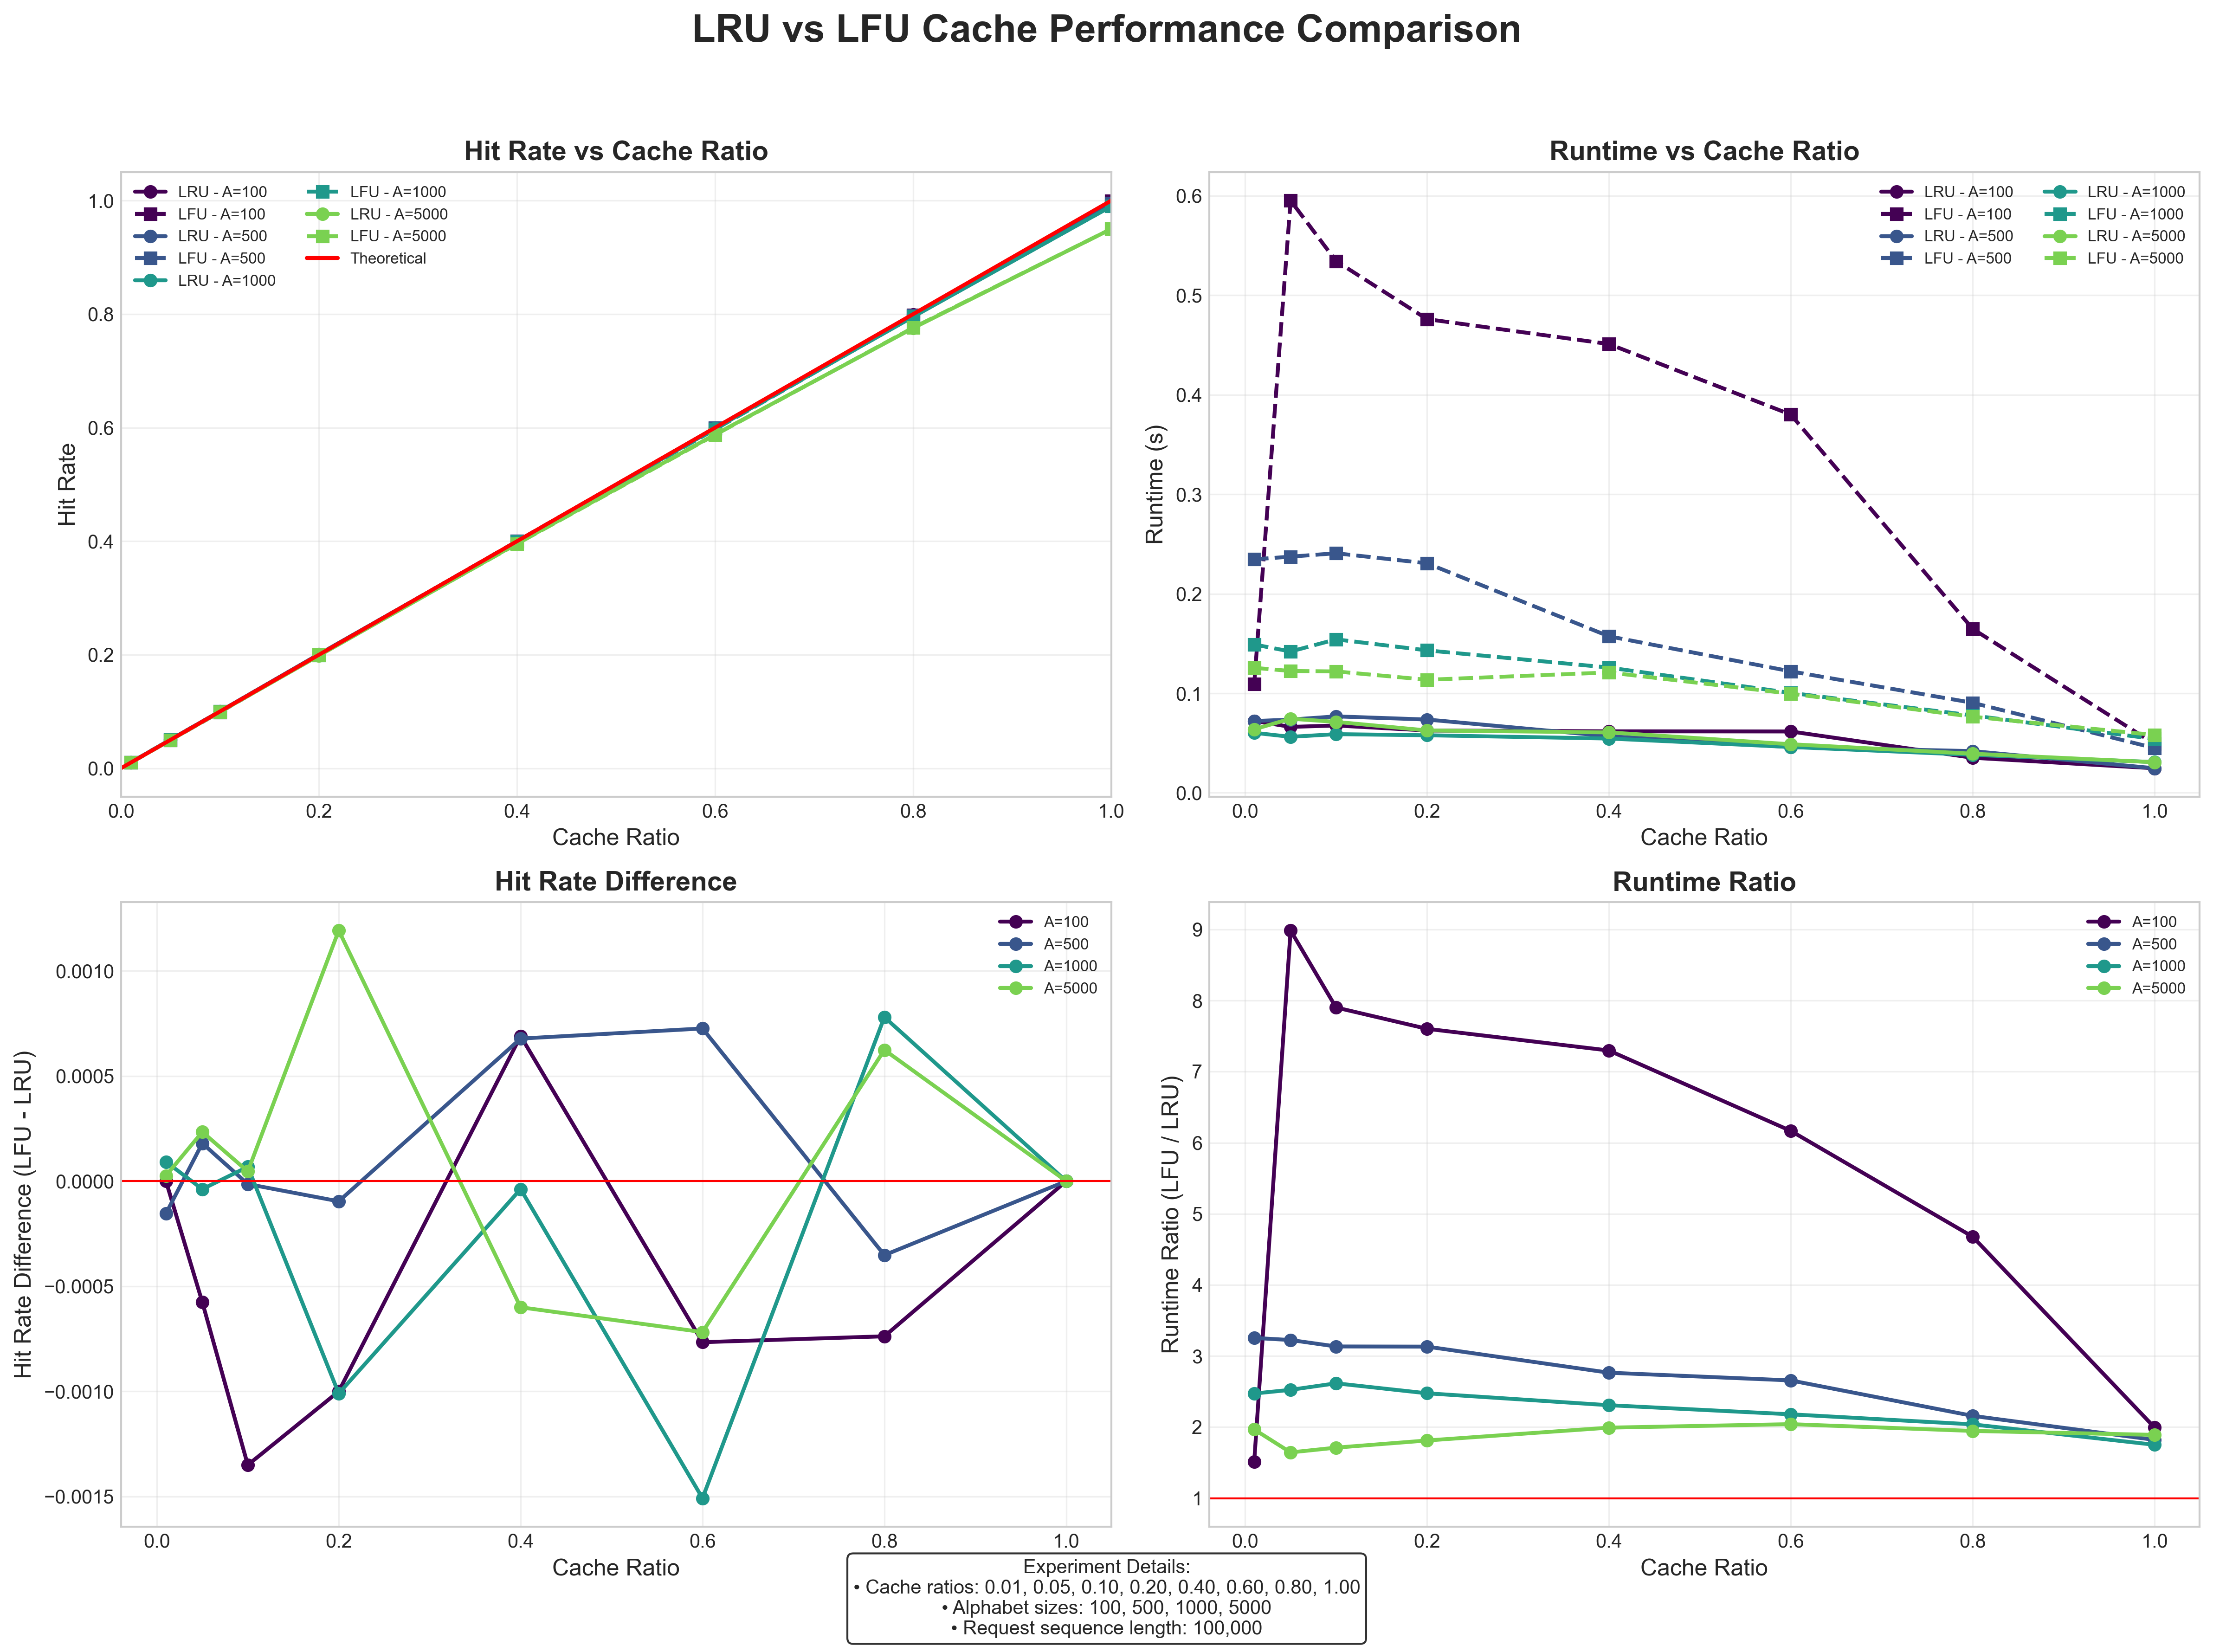

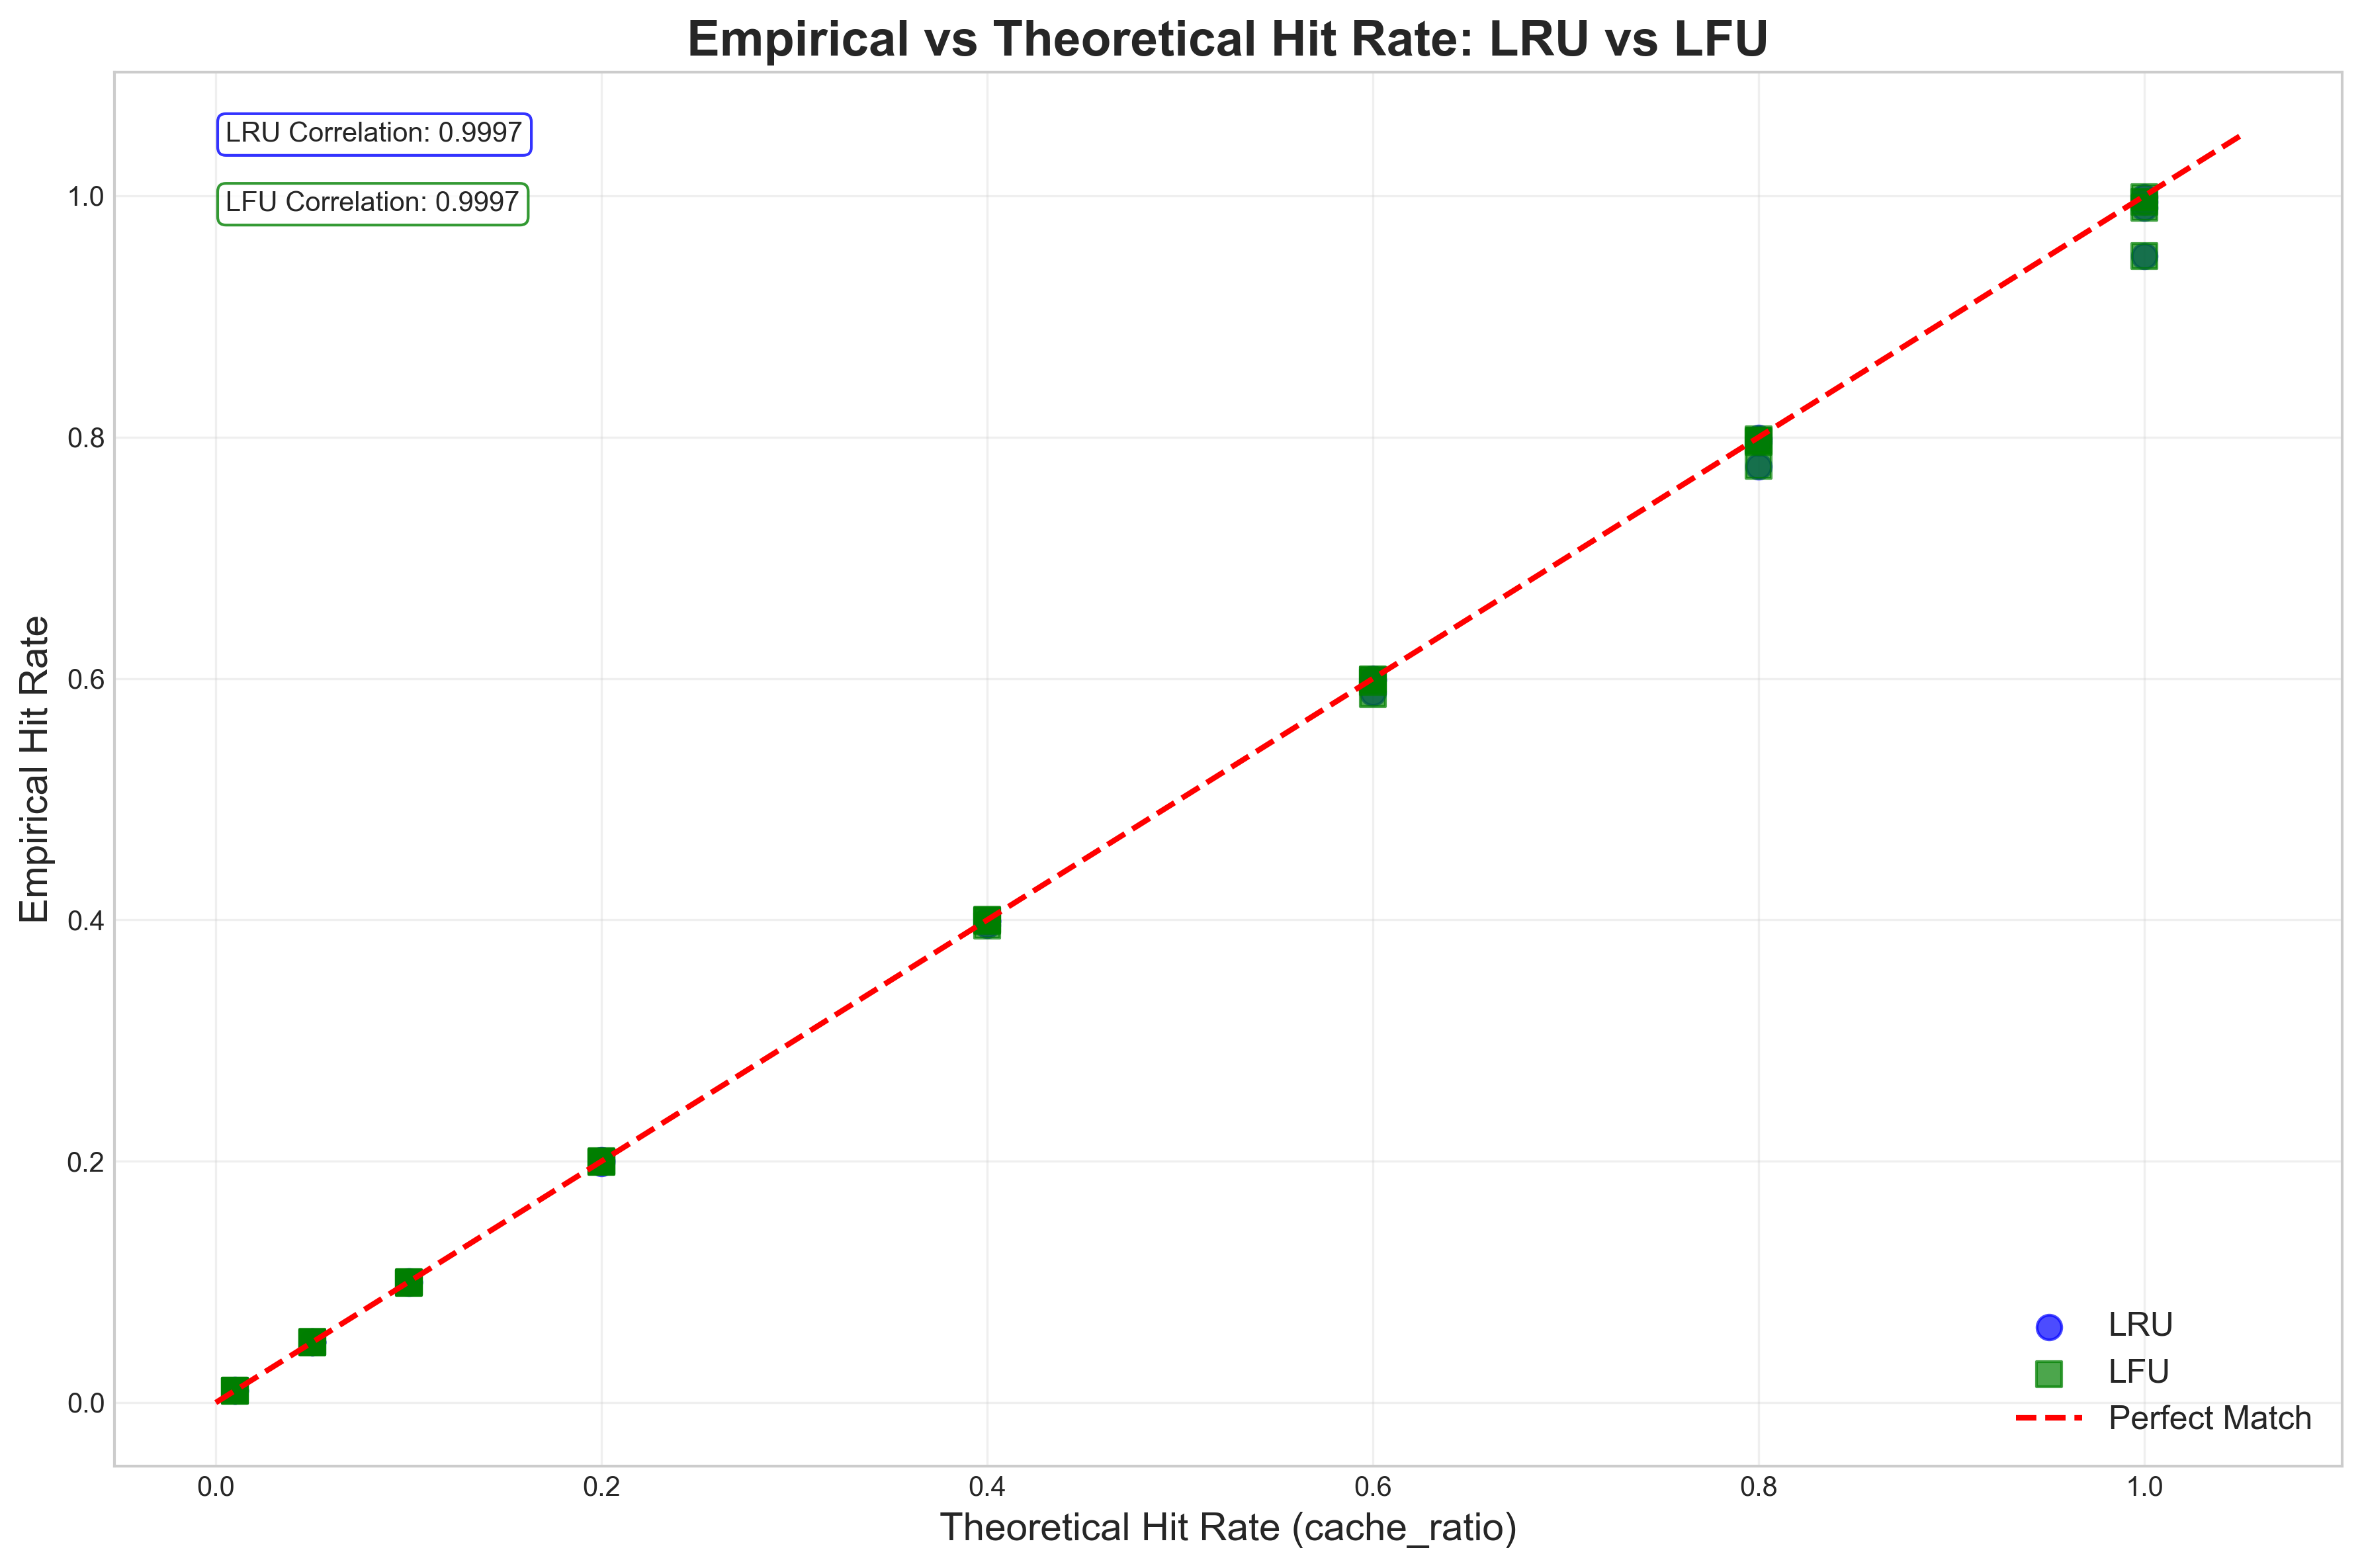

In [8]:
def main():
    # First create output directories
    create_output_directories()
    
    # Define experiment parameters
    alphabet_sizes = [100, 500, 1000, 5000]
    cache_ratios = [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]  # Only test up to 100% of alphabet size
    request_length = 100000  # Increased for more reliable results
    
    # Run experiments
    results = run_experiment(alphabet_sizes, cache_ratios, request_length)
    
    # Print results
    print("\nLRU Experiment Results:")
    print(results['lru'])
    print("\nLFU Experiment Results:")
    print(results['lfu'])
    
    # Calculate validation metrics
    lru_results = results['lru']
    lfu_results = results['lfu']
    
    lru_results['theoretical_hit_rate'] = lru_results['cache_ratio']  # For uniform distribution
    lru_results['hit_rate_difference'] = abs(lru_results['avg_hit_rate'] - lru_results['theoretical_hit_rate'])
    lru_correlation = np.corrcoef(lru_results['theoretical_hit_rate'], lru_results['avg_hit_rate'])[0, 1]
    
    lfu_results['theoretical_hit_rate'] = lfu_results['cache_ratio']  # For uniform distribution
    lfu_results['hit_rate_difference'] = abs(lfu_results['avg_hit_rate'] - lfu_results['theoretical_hit_rate'])
    lfu_correlation = np.corrcoef(lfu_results['theoretical_hit_rate'], lfu_results['avg_hit_rate'])[0, 1]
    
    # Create visualizations
    plot_comparison_results(results, request_length)
    
    # Add this after the plot_comparison_results call
    plot_empirical_vs_theoretical(results)

    # Print validation statistics
    print("\nLRU Validation against theoretical model:")
    print(f"Average difference between empirical and theoretical hit rates: {lru_results['hit_rate_difference'].mean():.4f}")
    print(f"Maximum difference: {lru_results['hit_rate_difference'].max():.4f}")
    print(f"Correlation coefficient: {lru_correlation:.4f}")
    
    print("\nLFU Validation against theoretical model:")
    print(f"Average difference between empirical and theoretical hit rates: {lfu_results['hit_rate_difference'].mean():.4f}")
    print(f"Maximum difference: {lfu_results['hit_rate_difference'].max():.4f}")
    print(f"Correlation coefficient: {lfu_correlation:.4f}")
    
    # Save results to CSV
    lru_results.to_csv('output/csv/lru_cache_results.csv', index=False)
    lfu_results.to_csv('output/csv/lfu_cache_results.csv', index=False)
    print("\nResults saved to output/csv/lru_cache_results.csv and output/csv/lfu_cache_results.csv")
    
    # Generate a comparison summary
    comparison = pd.DataFrame({
        'Metric': [
            'Average Hit Rate',
            'Maximum Hit Rate',
            'Average Runtime (s)',
            'Average Memory Usage (KB)',
            'Theoretical Model Correlation'
        ],
        'LRU': [
            f"{lru_results['avg_hit_rate'].mean():.4f}",
            f"{lru_results['avg_hit_rate'].max():.4f}",
            f"{lru_results['avg_runtime'].mean():.4f}",
            f"{(lru_results['avg_memory_usage'].mean() / 1024):.2f}",
            f"{lru_correlation:.4f}"
        ],
        'LFU': [
            f"{lfu_results['avg_hit_rate'].mean():.4f}",
            f"{lfu_results['avg_hit_rate'].max():.4f}",
            f"{lfu_results['avg_runtime'].mean():.4f}",
            f"{(lfu_results['avg_memory_usage'].mean() / 1024):.2f}",
            f"{lfu_correlation:.4f}"
        ]
    })
    
    # Save comparison to CSV
    comparison.to_csv('output/csv/lru_vs_lfu_comparison.csv', index=False)
    print("\nComparison saved to output/csv/lru_vs_lfu_comparison.csv")
    
    # Create presentation-ready text summary
    with open('output/txt/cache_comparison_summary.txt', 'w') as f:
        f.write("LRU VS LFU CACHE PERFORMANCE WITH UNIFORM RANDOM ACCESS\n")
        f.write("=======================================================\n\n")
        f.write("EXECUTIVE SUMMARY:\n")
        f.write(f"- Tested {len(lru_results)} configurations for both LRU and LFU caches\n")
        f.write(f"- LRU Average hit rate: {lru_results['avg_hit_rate'].mean():.4f}\n")
        f.write(f"- LFU Average hit rate: {lfu_results['avg_hit_rate'].mean():.4f}\n")
        f.write(f"- LRU-Theoretical correlation: {lru_correlation:.4f}\n")
        f.write(f"- LFU-Theoretical correlation: {lfu_correlation:.4f}\n\n")
        
        f.write("KEY FINDINGS:\n")
        f.write("1. Both LRU and LFU hit rates closely match theoretical predictions for uniform distribution\n")
        f.write(f"2. LFU runtime is {(lfu_results['avg_runtime'].mean() / lru_results['avg_runtime'].mean() - 1) * 100:.1f}% higher than LRU\n")
        f.write(f"3. LFU memory usage is {(lfu_results['avg_memory_usage'].mean() / lru_results['avg_memory_usage'].mean() - 1) * 100:.1f}% higher than LRU\n")
        f.write("4. For uniform random access, both algorithms have similar hit rates\n\n")
        
        f.write("RECOMMENDATIONS:\n")
        f.write("1. For uniform access distributions, LRU is generally preferable due to lower overhead\n")
        f.write("2. Cache-to-alphabet ratio is the primary determinant of hit rate for both algorithms\n")
        f.write("3. LFU may be more beneficial for non-uniform distributions with frequently recurring items\n")
    
    print("\nComparison summary saved to output/txt/cache_comparison_summary.txt")

if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    main()

LRU VS LFU CACHE PERFORMANCE WITH UNIFORM RANDOM ACCESS
=======================================================

EXECUTIVE SUMMARY:
- Tested 32 configurations for both LRU and LFU caches
- LRU Average hit rate: 0.3912
- LFU Average hit rate: 0.3911
- LRU-Theoretical correlation: 0.9997
- LFU-Theoretical correlation: 0.9997

KEY FINDINGS:
1. Both LRU and LFU hit rates closely match theoretical predictions for uniform distribution
2. LFU runtime is 215.1% higher (slower) than LRU
3. LFU memory usage is 62.5% higher (bigger) than LRU
4. For uniform random access, both algorithms have similar hit rates

RECOMMENDATIONS:
1. For uniform access distributions, LRU is generally preferable due to lower overhead
2. Cache-to-alphabet ratio is the primary determinant of hit rate for both algorithms
3. LFU may be more beneficial for non-uniform distributions with frequently recurring items
